## Multiple linear regression

This notebook loads in the master data frame. It splits the dataframe into a test and train set. Then, feature selection is performed on the training set by backwards elimination with cross-validation, with the stopping point determined by the model with the lowest average validation MSE. Lasso cross-validation is also performed to obtain another linear regression model. Both models are run on the test data set, and both have comparable MSE on test.

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
#import diagnostic_plots
import pickle
import time

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold

%matplotlib inline

/Users/joycelee/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('master_df.pkl', 'rb') as picklefile:
    master_df = pickle.load(picklefile)

In [3]:
master_df.head()

,crude_rate,median_age,percent_white,hs_percent,median_hh_income,percent_unemployed,percent_poverty,opioid_rx_rate_2016,opioid_rx_rate_2015,opioid_rx_rate_2014,pmp_age_in_2016,Division_East North Central,Division_East South Central,Division_Middle Atlantic,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central
INCITS,,,,,,,,,,,,,,,,,,,,
01003,16.300000,42.3,86.4,90.0,51365,3.7,9.3,123.8,132.1,143.5,10,0,1,0,0,0,0,0,0,0
01009,25.994732,40.8,95.4,80.0,46212,3.0,12.2,56.9,57.9,63.2,10,0,1,0,0,0,0,0,0,0
01015,13.960266,39.1,74.9,82.3,41954,6.7,15.8,161.0,165.4,180.0,10,0,1,0,0,0,0,0,0,0
01043,24.300000,40.5,95.9,82.2,39297,3.2,12.0,166.2,172.0,182.6,10,0,1,0,0,0,0,0,0,0
01049,26.798307,39.3,87.2,72.6,38248,3.4,14.3,114.4,117.6,122.7,10,0,1,0,0,0,0,0,0,0


In [4]:
master_df.columns

Index(['crude_rate', 'median_age', 'percent_white', 'hs_percent',
       'median_hh_income', 'percent_unemployed', 'percent_poverty',
       'opioid_rx_rate_2016', 'opioid_rx_rate_2015', 'opioid_rx_rate_2014',
       'pmp_age_in_2016', 'Division_East North Central',
       'Division_East South Central', 'Division_Middle Atlantic',
       'Division_Mountain', 'Division_New England', 'Division_Pacific',
       'Division_South Atlantic', 'Division_West North Central',
       'Division_West South Central'],
      dtype='object')

In [5]:
# We will drop Division_New England in order to make that our default dummy.
master_df = master_df.drop(columns=['Division_New England'])

In [6]:
# Let's check the correlations to see which variables already have a strong correlation with the target variable.
# This will also help pick which year's opioid prescribing rate to use, 2014, 2015, or 2016.

# Looking at this grid, it looks like the opioid prescribing rate in 2014 has the strongest correlation
# coefficient, so we can use that.

# It is also apparent from this grid that several of the predictors have strong correlation with each other.

master_df.corr()

,crude_rate,median_age,percent_white,hs_percent,median_hh_income,percent_unemployed,percent_poverty,opioid_rx_rate_2016,opioid_rx_rate_2015,opioid_rx_rate_2014,pmp_age_in_2016,Division_East North Central,Division_East South Central,Division_Middle Atlantic,Division_Mountain,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central
crude_rate,1.000000,0.351150,0.245523,-0.131143,-0.280544,0.062553,0.171475,0.249784,0.286773,0.297783,-0.054040,0.085736,0.139757,0.078068,-0.028433,-0.170754,0.053321,-0.125143,-0.180807
median_age,0.351150,1.000000,0.409715,0.100251,-0.076277,-0.120580,-0.186242,0.198307,0.210408,0.201710,-0.050691,0.018677,0.024160,0.155810,-0.111309,-0.056160,0.098648,-0.120049,-0.242904
percent_white,0.245523,0.409715,1.000000,0.182633,-0.060970,-0.448630,-0.309757,0.177440,0.200487,0.204238,-0.037825,0.216903,0.101933,0.062609,0.012093,-0.136305,-0.251960,0.082812,-0.135238
hs_percent,-0.131143,0.100251,0.182633,1.000000,0.545210,-0.414961,-0.774924,-0.306633,-0.299944,-0.310617,-0.090350,0.194017,-0.199557,0.098123,0.037265,-0.068558,-0.121309,0.174616,-0.193406
median_hh_income,-0.280544,-0.076277,-0.060970,0.545210,1.000000,-0.320787,-0.763566,-0.525845,-0.526953,-0.521679,0.096659,-0.028825,-0.183357,0.139354,-0.028535,0.115822,-0.039781,0.048175,-0.082920
percent_unemployed,0.062553,-0.120580,-0.448630,-0.414961,-0.320787,1.000000,0.535208,0.123763,0.106848,0.100373,0.091128,-0.036576,-0.003766,-0.011019,0.013725,0.195539,0.127652,-0.179827,-0.125510
percent_poverty,0.171475,-0.186242,-0.309757,-0.774924,-0.763566,0.535208,1.000000,0.393153,0.388807,0.390504,-0.008072,-0.093039,0.199785,-0.152592,0.049495,-0.013154,0.077371,-0.117011,0.155841
opioid_rx_rate_2016,0.249784,0.198307,0.177440,-0.306633,-0.525845,0.123763,0.393153,1.000000,0.988565,0.972104,-0.192348,-0.027328,0.385379,-0.215719,-0.046426,-0.107826,0.067669,-0.072600,0.084202
opioid_rx_rate_2015,0.286773,0.210408,0.200487,-0.299944,-0.526953,0.106848,0.388807,0.988565,1.000000,0.989268,-0.188296,-0.018823,0.375908,-0.216453,-0.049132,-0.099192,0.059431,-0.066485,0.065709
opioid_rx_rate_2014,0.297783,0.201710,0.204238,-0.310617,-0.521679,0.100373,0.390504,0.972104,0.989268,1.000000,-0.182659,-0.004846,0.364899,-0.247576,-0.057376,-0.085495,0.062150,-0.058320,0.076004


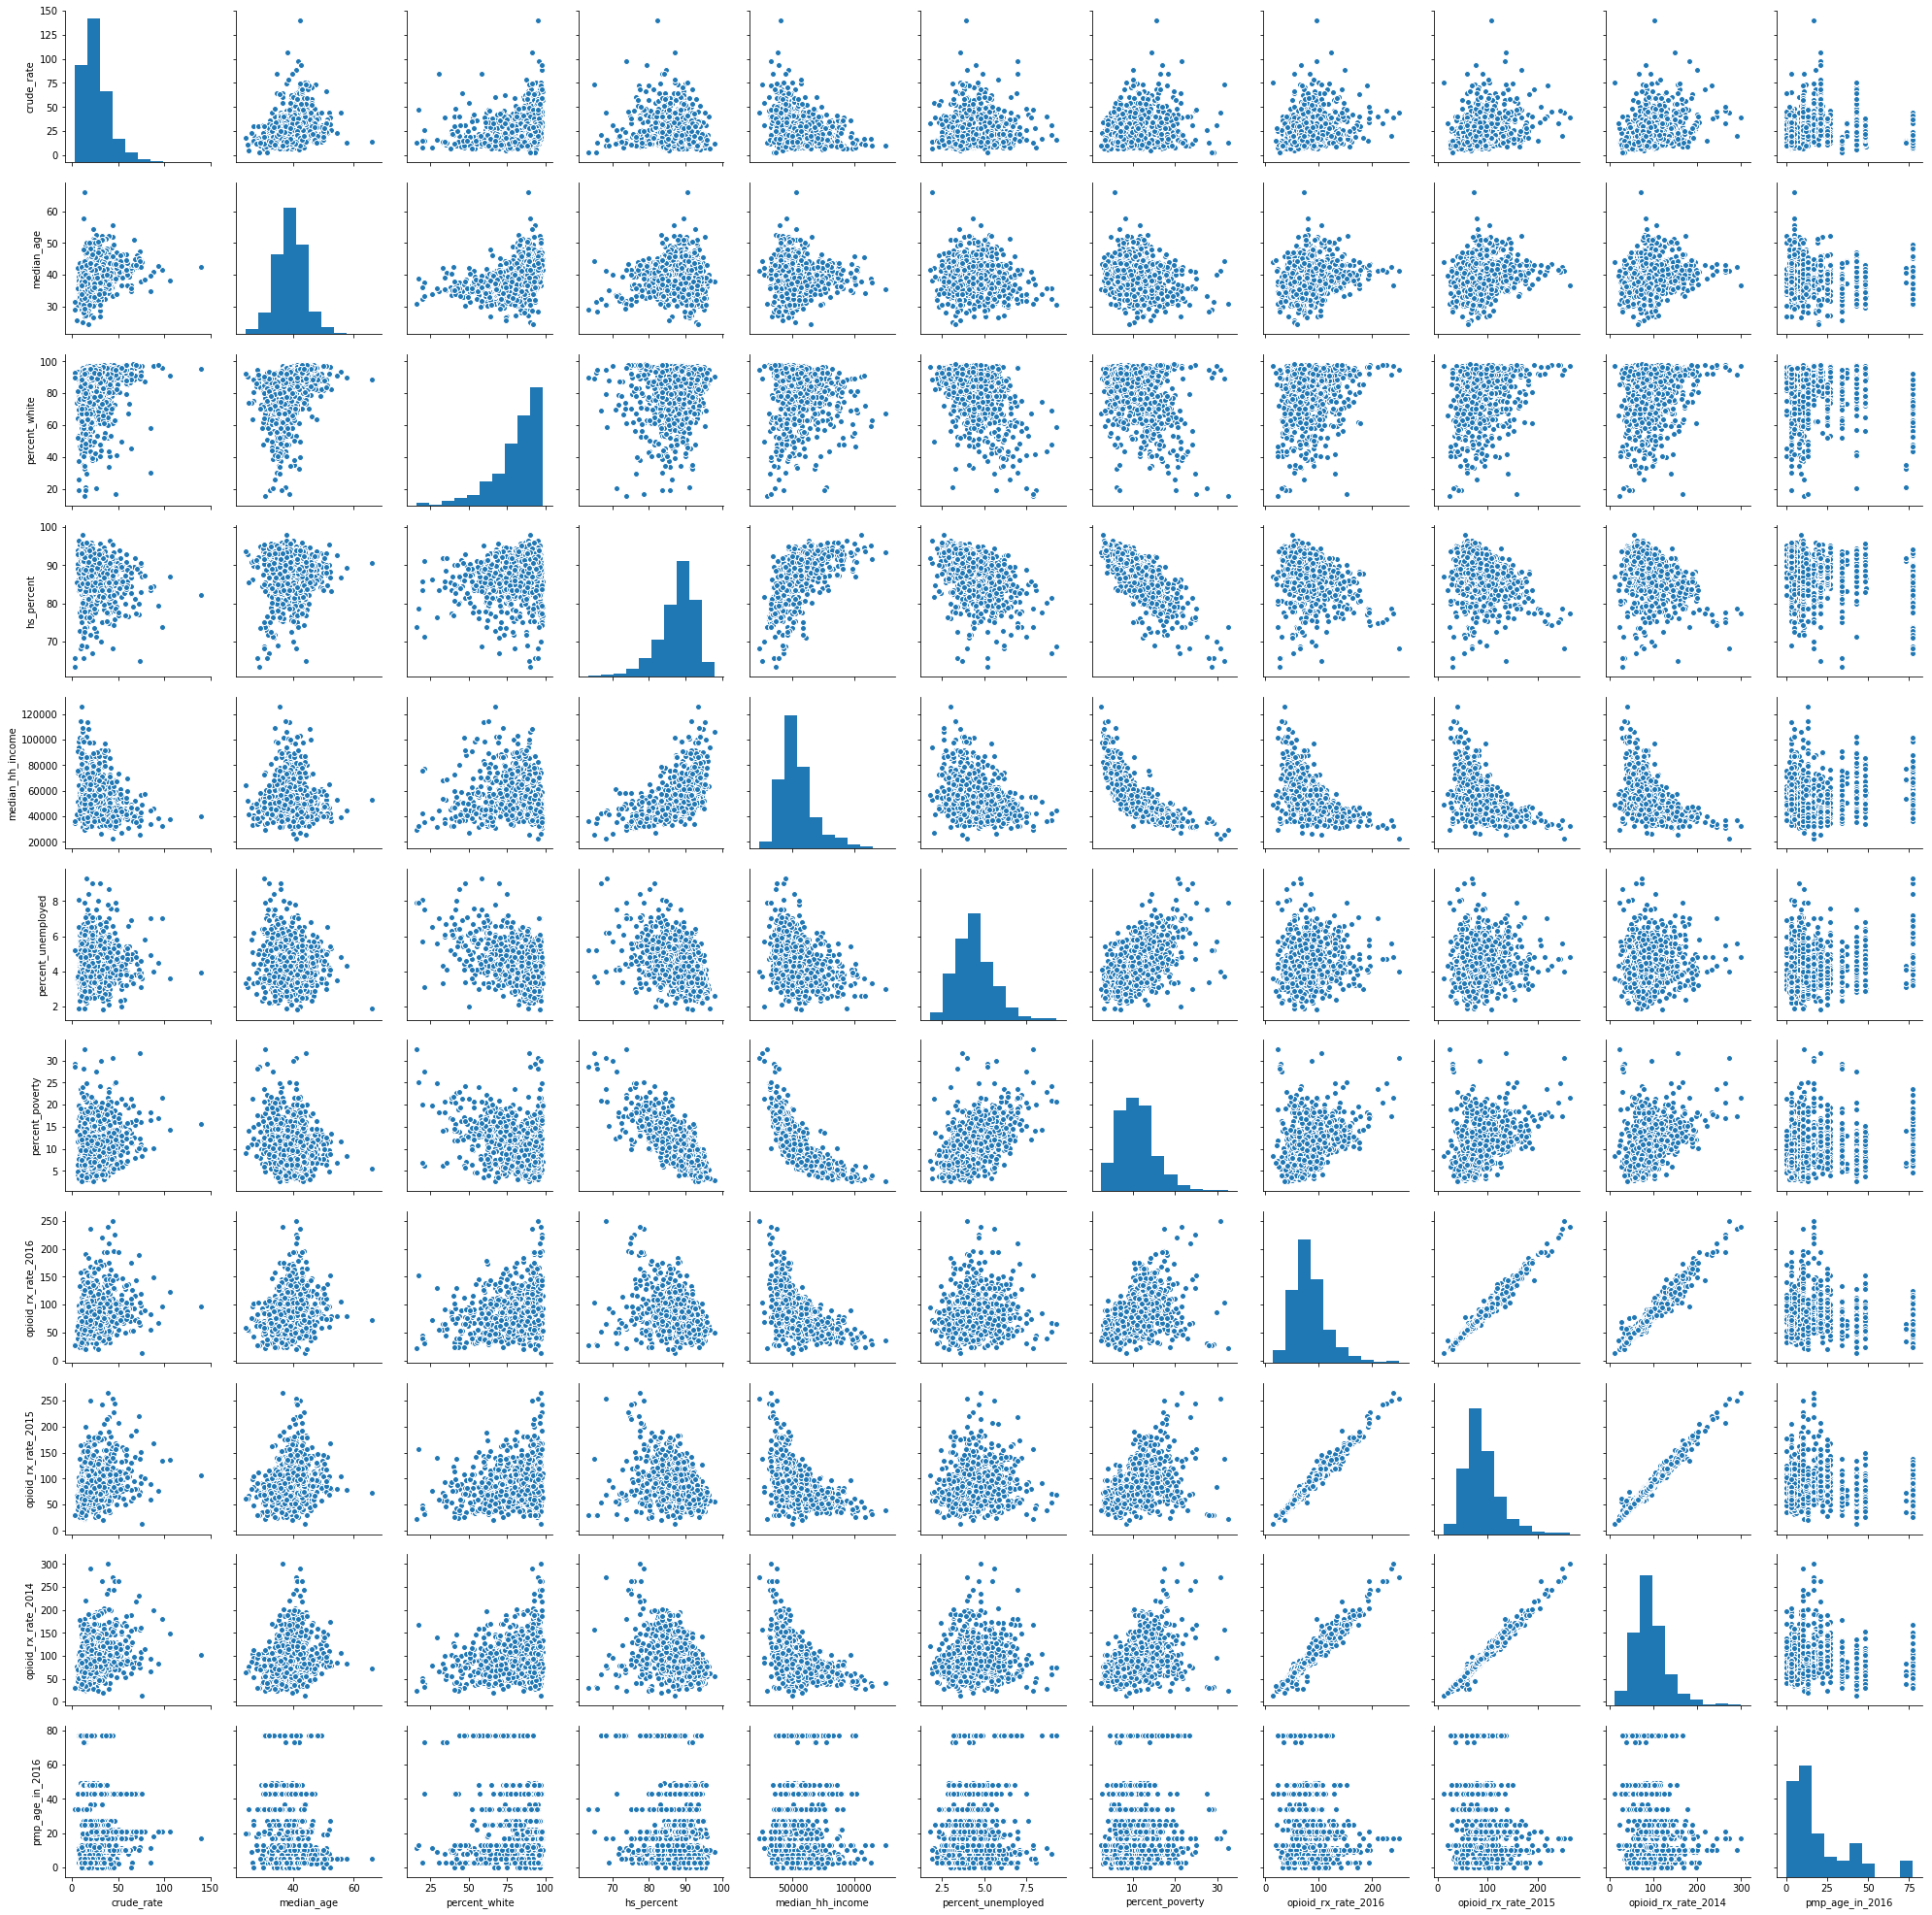

In [7]:
# Let's look at the pair plots for all the variables except for the dummies.
sns.pairplot(master_df, vars=['crude_rate', 'median_age', 'percent_white', 'hs_percent',
       'median_hh_income', 'percent_unemployed', 'percent_poverty',
       'opioid_rx_rate_2016', 'opioid_rx_rate_2015', 'opioid_rx_rate_2014',
       'pmp_age_in_2016'])

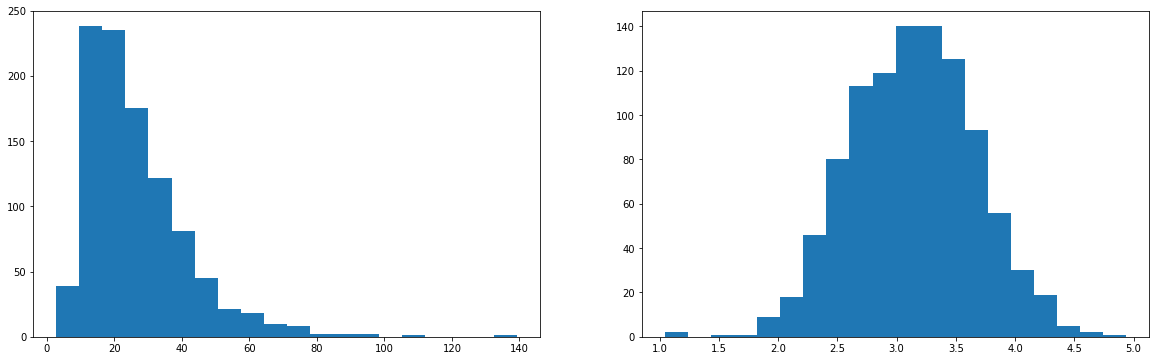

In [8]:
# We can see in the upper left-hand corner that the histogram of crude rate does not look like it has
# a Gaussian distribution. Let's plot a histogram of it.
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].hist(master_df['crude_rate'], 20)

ax[1].hist(np.log(master_df['crude_rate']), 20)
plt.show()

In [7]:
# Since the histogram of the log of the crude rate looks much better, we'll take the log of that column and
# rename it.
master_df['crude_rate'] = master_df['crude_rate'].apply(np.log)
master_df = master_df.rename(index=str, columns={'crude_rate': 'log_crude_rate'});

In [8]:
master_df = master_df.rename(columns=lambda x: x.replace(" ","_"))
master_df.columns
#master_df.head()

Index(['log_crude_rate', 'median_age', 'percent_white', 'hs_percent',
       'median_hh_income', 'percent_unemployed', 'percent_poverty',
       'opioid_rx_rate_2016', 'opioid_rx_rate_2015', 'opioid_rx_rate_2014',
       'pmp_age_in_2016', 'Division_East_North_Central',
       'Division_East_South_Central', 'Division_Middle_Atlantic',
       'Division_Mountain', 'Division_Pacific', 'Division_South_Atlantic',
       'Division_West_North_Central', 'Division_West_South_Central'],
      dtype='object')

Let's be extremely naive and run an OLS on the whole dataframe, and just see what we get back.

In [12]:
y = master_df['log_crude_rate']
X = master_df.drop(columns=['log_crude_rate'])

In [13]:
X.columns

Index(['median_age', 'percent_white', 'hs_percent', 'median_hh_income',
       'percent_unemployed', 'percent_poverty', 'opioid_rx_rate_2016',
       'opioid_rx_rate_2015', 'opioid_rx_rate_2014', 'pmp_age_in_2016',
       'Division_East_North_Central', 'Division_East_South_Central',
       'Division_Middle_Atlantic', 'Division_Mountain', 'Division_Pacific',
       'Division_South_Atlantic', 'Division_West_North_Central',
       'Division_West_South_Central'],
      dtype='object')

In [14]:
# We'll also drop the prescribing maps for 2015 and 2016, since 2014 shows the strongest correlation as 
# single variable for the target variable.
X = X.drop(columns=['opioid_rx_rate_2015', 'opioid_rx_rate_2016'])
X.head()

,median_age,percent_white,hs_percent,median_hh_income,percent_unemployed,percent_poverty,opioid_rx_rate_2014,pmp_age_in_2016,Division_East_North_Central,Division_East_South_Central,Division_Middle_Atlantic,Division_Mountain,Division_Pacific,Division_South_Atlantic,Division_West_North_Central,Division_West_South_Central
INCITS,,,,,,,,,,,,,,,,
01003,42.3,86.4,90.0,51365,3.7,9.3,143.5,10,0,1,0,0,0,0,0,0
01009,40.8,95.4,80.0,46212,3.0,12.2,63.2,10,0,1,0,0,0,0,0,0
01015,39.1,74.9,82.3,41954,6.7,15.8,180.0,10,0,1,0,0,0,0,0,0
01043,40.5,95.9,82.2,39297,3.2,12.0,182.6,10,0,1,0,0,0,0,0,0
01049,39.3,87.2,72.6,38248,3.4,14.3,122.7,10,0,1,0,0,0,0,0,0


In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

ssX = StandardScaler()
X_scaled = ssX.fit_transform(X.iloc[:, :-8])
# After you run StandardScaler() on your X dataframe, you can then run X_scaled through Lasso or Ridge since
# the x-values are then normalized.

poly = PolynomialFeatures(2)
X_quad = poly.fit_transform(X_scaled)

X_features = np.concatenate([X_quad, X.iloc[:,-8:]], axis=1)

In [16]:
X_features2 = pd.DataFrame(X_features, columns=[list(poly.get_feature_names()) + list(X.columns[-8:])])
X_features2.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x0^2,...,x6 x7,x7^2,Division_East_North_Central,Division_East_South_Central,Division_Middle_Atlantic,Division_Mountain,Division_Pacific,Division_South_Atlantic,Division_West_North_Central,Division_West_South_Central
0,1.0,0.652838,0.346364,0.469973,-0.162935,-0.676439,-0.389647,1.285586,-0.490814,0.426197,...,-0.630983,0.240898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.331042,0.956553,-1.469500,-0.526234,-1.308709,0.257200,-0.824577,-0.490814,0.109589,...,0.404714,0.240898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,-0.033660,-0.433322,-1.023421,-0.826434,2.033290,1.060183,2.244751,-0.490814,0.001133,...,-1.101755,0.240898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.266683,0.990452,-1.042816,-1.013759,-1.128060,0.212590,2.313075,-0.490814,0.071120,...,-1.135289,0.240898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.009246,0.400603,-2.904710,-1.087716,-0.947412,0.725607,0.738993,-0.490814,0.000085,...,-0.362708,0.240898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Create your model using statsmodel
model = sm.OLS(y, X_features2.values)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_crude_rate   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     13.84
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           4.72e-84
Time:                        09:43:09   Log-Likelihood:                -487.10
No. Observations:                1000   AIC:                             1080.
Df Residuals:                     947   BIC:                             1340.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5101      0.070     49.850      0.000       3.372       3.648
x1             0.1395      0.022      6.278      0.000       0.096       0.183
x2             0.1087      0.029      3.742      0.000       0.052       0.166
x3            -0.0560      0.032     -1.762      0.078      -0.118       0.006
x4             0.0475      0.048      0.985      0.325      -0.047       0.142
x5             0.0312      0.021      1.513      0.131      -0.009       0.072
x6             0.1133      0.049      2.291      0.022       0.016       0.210
x7             0.1533      0.026      5.949      0.000       0.103       0.204
x8             0.0569      0.029      1.937      0.053      -0.001       0.115
x9            -0.0266      0.010     -2.570      0.010      -0.047      -0.006
x10           -0.0017      0.025     -0.069      0.945      -0.052       0.048
x11           -0.0442      0.028     -1.554      0.121      -0.100       0.012
x12           -0.0197      0.034     -0.579      0.563      -0.086       0.047
x13           -0.0197      0.018     -1.083      0.279      -0.055       0.016
x14            0.0021      0.042      0.050      0.960      -0.081       0.085
x15           -0.0140      0.024     -0.577      0.564      -0.062       0.034
x16            0.0184      0.018      1.022      0.307      -0.017       0.054
x17            0.0091      0.015      0.612      0.541      -0.020       0.038
x18           -0.0347      0.031     -1.106      0.269      -0.096       0.027
x19           -0.0190      0.040     -0.472      0.637      -0.098       0.060
x20           -0.0104      0.022     -0.474      0.636      -0.053       0.033
x21           -0.0362      0.044     -0.826      0.409      -0.122       0.050
x22            0.0416      0.022      1.852      0.064      -0.002       0.086
x23           -0.0230      0.019     -1.209      0.227      -0.060       0.014
x24           -0.0183      0.022     -0.818      0.414      -0.062       0.026
x25           -0.0137      0.054     -0.252      0.801      -0.120       0.093
x26           -0.0070      0.027     -0.259      0.796      -0.060       0.046
x27            0.0180      0.063      0.284      0.776      -0.106       0.142
x28           -0.0330      0.031     -1.081      0.280      -0.093       0.027
x29           -0.0199      0.021     -0.925      0.355      -0.062       0.022
x30            0.0088      0.033      0.265      0.791      -0.056       0.074
x31            0.0654      0.036      1.810      0.071      -0.006       0.136
x32           -0.1171      0.081     -1.443      0.149      -0.276       0.042
x33            0.1387      0.046      3.002      0.003       0.048       0.229
x34           -0.0153      0.029     -0.524      0.600      -0.073       0.042
x35            0.0225      0.014      1.620      0.106      -0.005       0.050
x3

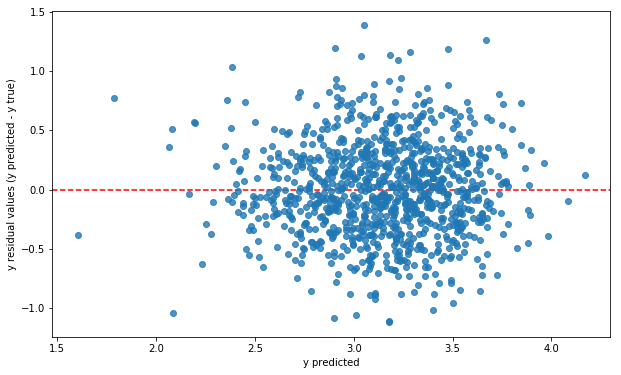

In [18]:
y_true = np.asarray(y)

y_predict = fit.predict(X_features2)

y_resid = y_true.reshape(-1,) - y_predict

plt.figure(figsize=(10,6))
plt.xlabel('y predicted')
plt.ylabel('y residual values (y predicted - y true)')
plt.axhline(y=0, color='red', linestyle="--")
plt.plot(y_predict, y_resid, 'o', alpha=0.8)

fig = plt.gcf()
fig.savefig('pics/residual_plot.png')

## Hold out final test data set

First, let's split the data using test_train_split so that you have a final test data set.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# X_final_test and y_final_test are the final test set that will be used at the very end.
X_tr, X_final_test, y_tr, y_final_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Now that we have taken our final test set out of the data, we need to use StandardScaler on X_tr in order
# to normalize it. We keep the scaler object, and use it to transform X_final_test so that we use the
# training parameters to scale the test dataset.

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

ssX = StandardScaler()
X_tr_scaled = ssX.fit_transform(X_tr.iloc[:, :-8])
# After you run StandardScaler() on your X dataframe, you can then run X_scaled through Lasso or Ridge since
# the x-values are then normalized.

poly = PolynomialFeatures(2)
X_tr_quad = poly.fit_transform(X_tr_scaled)

X_tr_features = np.concatenate([X_tr_quad, X_tr.iloc[:,-8:]], axis=1)

In [23]:
X_tr_features2 = pd.DataFrame(X_tr_features, columns=[list(poly.get_feature_names()) + list(X_tr.columns[-8:])])
X_tr_features2.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x0^2,...,x6 x7,x7^2,Division_East_North_Central,Division_East_South_Central,Division_Middle_Atlantic,Division_Mountain,Division_Pacific,Division_South_Atlantic,Division_West_North_Central,Division_West_South_Central
0,1.0,2.209759,0.564298,-0.745805,-0.967038,0.691238,0.507581,1.253054,-0.592979,4.883035,...,-0.743035,0.351625,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.632303,0.557433,0.240644,0.454011,-0.946982,-0.777504,-0.903420,1.338550,2.664412,...,-1.209272,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,-0.207002,0.303430,0.003896,0.037968,-1.766092,-0.356528,-0.887426,0.345192,0.042850,...,-0.306332,0.119157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,-0.313938,-2.806387,-1.377133,0.442818,0.509213,0.175231,-1.855040,1.338550,0.098557,...,-2.483063,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.113807,0.722192,-1.791442,-1.222842,0.054152,0.928557,1.994091,-0.482606,0.012952,...,-0.962361,0.232909,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
rename_features = list(X_tr_features2.columns.get_level_values(0))
feature_dict = {'x0': 'median_age', 'x1': 'percent_white', 'x2': 'hs_percent', 'x3': 'median_hh_income', \
                'x4': 'percent_unemployed', 'x5': 'percent_poverty', 'x6': 'opioid_rx_rate_2014', 'x7': 'pmp_age_in_2016'}

In [25]:
# Rename all of the features to replace the x0, x1 etc. notation with the predictor names again.
# Run through the list twice to appropriately replace both terms in the combination terms.
for i in range(0, 2):
    for index, renamed_feature in enumerate(rename_features):
        for x_name in feature_dict.keys():
            #print(x_name)
            if x_name in renamed_feature:
                replace_feature = renamed_feature.replace(x_name, feature_dict[x_name])
                rename_features[index] = replace_feature

In [26]:
rename_features[0] = 'const'

In [27]:
temp = X_tr_features2.T.reset_index(drop=True).T
temp.columns = rename_features

In [28]:
X_tr_features2 = temp

In [29]:
# All of the other processing steps that happend before (scaling, adding quad features, etc.) got rid of INCITS
# as the index, need to get the index from X_tr and restore it.
orig_index = X_tr.index
X_tr_features2.index = orig_index

In [30]:
with open('X_tr_features2.pkl', 'wb') as picklefile:
    pickle.dump(X_tr_features2, picklefile)

In [31]:
X_tr_features2.head()

,const,median_age,percent_white,hs_percent,median_hh_income,percent_unemployed,percent_poverty,opioid_rx_rate_2014,pmp_age_in_2016,median_age^2,...,opioid_rx_rate_2014 pmp_age_in_2016,pmp_age_in_2016^2,Division_East_North_Central,Division_East_South_Central,Division_Middle_Atlantic,Division_Mountain,Division_Pacific,Division_South_Atlantic,Division_West_North_Central,Division_West_South_Central
INCITS,,,,,,,,,,,,,,,,,,,,,
04015,1.0,2.209759,0.564298,-0.745805,-0.967038,0.691238,0.507581,1.253054,-0.592979,4.883035,...,-0.743035,0.351625,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36021,1.0,1.632303,0.557433,0.240644,0.454011,-0.946982,-0.777504,-0.903420,1.338550,2.664412,...,-1.209272,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
40051,1.0,-0.207002,0.303430,0.003896,0.037968,-1.766092,-0.356528,-0.887426,0.345192,0.042850,...,-0.306332,0.119157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36081,1.0,-0.313938,-2.806387,-1.377133,0.442818,0.509213,0.175231,-1.855040,1.338550,0.098557,...,-2.483063,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47177,1.0,0.113807,0.722192,-1.791442,-1.222842,0.054152,0.928557,1.994091,-0.482606,0.012952,...,-0.962361,0.232909,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Backwards elimination, on K-fold cross-validation.

Steps:
1. Split X_tr into n folds (let's pick 4).
2. Iterate throuch each fold. For each fold, pick the least significant feature. There are n folds, so there are going to be n votes. For each round, take the majority pick of the least significant feature, and throw it out.
    * Also, capture the adjusted R2 and also the test and training error for each round.
3. For the next round, go through each fold again with the new model with one feature removed.
    * Keep repeating this until the all of the features left are significant.
    
* Plot the test and training error vs the number of features/predictors. Can also plot adjusted R2 vs # of features/predictors, and also R2.

In [32]:
# We're going to put a cell here to reload the dataframe into X_hold, because every time you iterate over the cells
# below, you change X_tr_features2 and then when you want to go back to the original dataframe, it's very annoying.
with open('X_tr_features2.pkl', 'rb') as picklefile:
    X_hold = pickle.load(picklefile)
    
feature_num = X_hold.shape[1] # feature_num is the number of columns

In [33]:
X_tr_features2 = X_hold

In [34]:
X_tr_features2.head()

,const,median_age,percent_white,hs_percent,median_hh_income,percent_unemployed,percent_poverty,opioid_rx_rate_2014,pmp_age_in_2016,median_age^2,...,opioid_rx_rate_2014 pmp_age_in_2016,pmp_age_in_2016^2,Division_East_North_Central,Division_East_South_Central,Division_Middle_Atlantic,Division_Mountain,Division_Pacific,Division_South_Atlantic,Division_West_North_Central,Division_West_South_Central
INCITS,,,,,,,,,,,,,,,,,,,,,
04015,1.0,2.209759,0.564298,-0.745805,-0.967038,0.691238,0.507581,1.253054,-0.592979,4.883035,...,-0.743035,0.351625,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36021,1.0,1.632303,0.557433,0.240644,0.454011,-0.946982,-0.777504,-0.903420,1.338550,2.664412,...,-1.209272,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
40051,1.0,-0.207002,0.303430,0.003896,0.037968,-1.766092,-0.356528,-0.887426,0.345192,0.042850,...,-0.306332,0.119157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36081,1.0,-0.313938,-2.806387,-1.377133,0.442818,0.509213,0.175231,-1.855040,1.338550,0.098557,...,-2.483063,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47177,1.0,0.113807,0.722192,-1.791442,-1.222842,0.054152,0.928557,1.994091,-0.482606,0.012952,...,-0.962361,0.232909,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
## Use a for loop to remove features from X_tr sequentially. We'll run through this 3 times and inspect the values.
# Get X_tr again in case you already changed it by running the cell below.
#X_tr, X_final_test, y_tr, y_final_test = train_test_split(X, y, test_size=0.2, random_state=42)

kf = KFold(n=len(X_tr), n_folds=8, random_state=42)

model_eval_dict = {'r2_adj': [], 'train_MSE': [], 'test_MSE': [], 'worst_feature': [], 'worst_pvalues': []}

L = 1

for i in range(0, feature_num-L):
    r2_adj_list = []
    worst_feature_list = []
    worst_pvalue_list = []
    train_MSE_list = []
    test_MSE_list = []
    largest_pvalue_list = []
    
    for train_index, test_index in kf:
        model = sm.OLS(y_tr.iloc[train_index], X_tr_features2.iloc[train_index])
        fit = model.fit()

        train_MSE = sum((fit.fittedvalues - y_tr.iloc[train_index])**2)/len(train_index)

        y_pred_test = fit.predict(X_tr_features2.iloc[test_index])
        test_MSE = sum((y_pred_test - y_tr.iloc[test_index])**2)/len(test_index)

        r2_adj_list.append(fit.rsquared_adj)
        features_without_const = fit.pvalues.drop('const')
        worst_feature_list.append(features_without_const.idxmax())
        worst_pvalue_list.append(max(features_without_const))
        train_MSE_list.append(train_MSE)
        test_MSE_list.append(test_MSE)
    
    model_eval_dict['r2_adj'].append(np.asarray(r2_adj_list).mean())
    model_eval_dict['train_MSE'].append(np.asarray(train_MSE_list).mean())
    model_eval_dict['test_MSE'].append(np.asarray(test_MSE_list).mean())
    model_eval_dict['worst_pvalues'].append(worst_pvalue_list)
    
    # I want to start looking at the model summaries where all the 'worst pvalues' are less than 0.05.
    # We'll just look at the last model summary that was generated.
#     if all(i < 0.05 for i in worst_pvalue_list):
#         with open('model_summaries.txt', 'a') as f:
#             f.write("Round number: " + str(i))
#             f.write(fit.summary().as_text())
#             f.write("\n\n")
    
    worst_feature = max(worst_feature_list, key=worst_feature_list.count)
    model_eval_dict['worst_feature'].append(worst_feature)
    X_tr_features2 = X_tr_features2.drop(columns=[worst_feature])

In [36]:
# The loop below prints out the round # where the worst p value is less than 0.05 for every entry on the
# worst_pvalues list, and given that output it looks like it's only until round 35 that the worst pvalue
# is less than 0.05.

# However, p-values are probably not the best way to evaluate the significance of the coefficients, especially
# since with expanding the basis functions, I think that you end up making multiple comparisons, and so I think
# you would have to makea bonferroni correction. Therefore, I think the cutoff threshold would end up being
# 0.05/??53??, which would end up being 0.0001?!

# model_eval_dict['worst_pvalues']

# for index, entry in enumerate(model_eval_dict['worst_pvalues']):
#     if all(i < 0.05 for i in entry):
#         print(index)

In [37]:
# We can find where the lowest test_MSE is located, and figure out how many features were removed at that point.
model_eval_dict['test_MSE']
lowest_test_MSE = min(model_eval_dict['test_MSE'])
num_features_removed = np.argmin(model_eval_dict['test_MSE'])
print(lowest_test_MSE)

0.17057180029787766


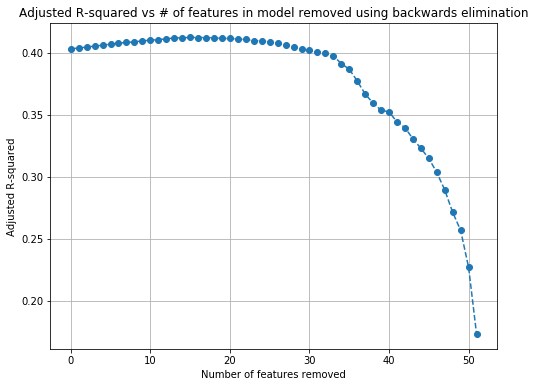

In [40]:
x_axis = range(0, feature_num-L, 1)
plt.figure(figsize=(8,6))
plt.title('Adjusted R-squared vs # of features in model removed using backwards elimination')
plt.ylabel('Adjusted R-squared')
plt.xlabel('Number of features removed')
plt.grid(True)
plt.plot(x_axis, model_eval_dict['r2_adj'], linestyle='--', marker='o')

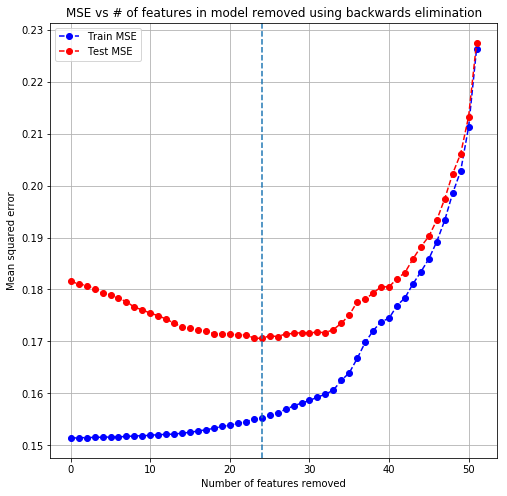

In [41]:
x_axis = range(0, feature_num-L, 1)
plt.figure(figsize=(8,8))
# plt.title('Adjusted R-squared vs # of features in model using backwards elimination')
plt.title('MSE vs # of features in model removed using backwards elimination')
plt.ylabel('Mean squared error')
plt.xlabel('Number of features removed')
train_MSE = plt.plot(x_axis, model_eval_dict['train_MSE'], '--bo', label="Train MSE")
test_MSE = plt.plot(x_axis, model_eval_dict['test_MSE'], '--ro', label="Test MSE")
plt.axvline(x=num_features_removed, linestyle='--')
plt.grid(True)
plt.legend()

fig = plt.gcf()
fig.savefig('pics/train_test_MSE.png', dpi=150, tranparent=True)

In [42]:
# We can look at model_eval_dict['worst_feature'] to see the sequence in which each feature was removed.
# From inspecting the plots above, it looks like when 24 features were removed and there are 52-24 = 28 predictors
# remaining in the model, it has the lowest test MSE and also has the highest adjusted R squared.
model_eval_dict['worst_feature']

['percent_unemployed percent_poverty',
 'hs_percent pmp_age_in_2016',
 'hs_percent percent_unemployed',
 'median_age opioid_rx_rate_2014',
 'percent_poverty^2',
 'median_age median_hh_income',
 'percent_white^2',
 'percent_white median_hh_income',
 'percent_poverty pmp_age_in_2016',
 'median_hh_income',
 'hs_percent median_hh_income',
 'percent_poverty opioid_rx_rate_2014',
 'percent_unemployed opioid_rx_rate_2014',
 'percent_white percent_poverty',
 'percent_white hs_percent',
 'median_age percent_poverty',
 'hs_percent^2',
 'median_hh_income^2',
 'pmp_age_in_2016^2',
 'hs_percent opioid_rx_rate_2014',
 'percent_white percent_unemployed',
 'opioid_rx_rate_2014 pmp_age_in_2016',
 'percent_white pmp_age_in_2016',
 'median_age pmp_age_in_2016',
 'median_age percent_white',
 'pmp_age_in_2016',
 'opioid_rx_rate_2014^2',
 'percent_unemployed',
 'percent_unemployed pmp_age_in_2016',
 'Division_Middle_Atlantic',
 'median_hh_income pmp_age_in_2016',
 'median_age percent_unemployed',
 'hs_perce

In [43]:
# Therefore, let's take a look at the model that excludes the first 24 predictors that backwards elimination
# got rid of.
backwards_elimination_features = model_eval_dict['worst_feature'][24:]

In [44]:
backwards_elimination_features

['median_age percent_white',
 'pmp_age_in_2016',
 'opioid_rx_rate_2014^2',
 'percent_unemployed',
 'percent_unemployed pmp_age_in_2016',
 'Division_Middle_Atlantic',
 'median_hh_income pmp_age_in_2016',
 'median_age percent_unemployed',
 'hs_percent',
 'percent_unemployed^2',
 'median_hh_income percent_unemployed',
 'median_age^2',
 'percent_white opioid_rx_rate_2014',
 'percent_white',
 'hs_percent percent_poverty',
 'median_hh_income percent_poverty',
 'Division_East_North_Central',
 'Division_Mountain',
 'Division_East_South_Central',
 'Division_South_Atlantic',
 'percent_poverty',
 'Division_Pacific',
 'Division_West_North_Central',
 'median_age hs_percent',
 'median_hh_income opioid_rx_rate_2014',
 'Division_West_South_Central',
 'opioid_rx_rate_2014',
 'median_age']

In [45]:
# We need to add back const to the backwards_elimination_features in order to run statsmodels on X_tr_features2.
backwards_elimination_features_with_const = ['const'] + backwards_elimination_features

In [46]:
X_tr_features2 = X_hold

In [47]:
X_tr_features2[backwards_elimination_features_with_const].head()

,const,median_age percent_white,pmp_age_in_2016,opioid_rx_rate_2014^2,percent_unemployed,percent_unemployed pmp_age_in_2016,Division_Middle_Atlantic,median_hh_income pmp_age_in_2016,median_age percent_unemployed,hs_percent,...,Division_East_South_Central,Division_South_Atlantic,percent_poverty,Division_Pacific,Division_West_North_Central,median_age hs_percent,median_hh_income opioid_rx_rate_2014,Division_West_South_Central,opioid_rx_rate_2014,median_age
INCITS,,,,,,,,,,,,,,,,,,,,,
04015,1.0,1.246962,-0.592979,1.570143,0.691238,-0.409890,0.0,0.573434,1.527469,-0.745805,...,0.0,0.0,0.507581,0.0,0.0,-1.648050,-1.211751,0.0,1.253054,2.209759
36021,1.0,0.909899,1.338550,0.816167,-0.946982,-1.267582,1.0,0.607716,-1.545761,0.240644,...,0.0,0.0,-0.777504,0.0,0.0,0.392805,-0.410162,0.0,-0.903420,1.632303
40051,1.0,-0.062811,0.345192,0.787525,-1.766092,-0.609640,0.0,0.013106,0.365585,0.003896,...,0.0,0.0,-0.356528,0.0,0.0,-0.000807,-0.033694,1.0,-0.887426,-0.207002
36081,1.0,0.881032,1.338550,3.441174,0.509213,0.681607,1.0,0.592734,-0.159862,-1.377133,...,0.0,0.0,0.175231,0.0,0.0,0.432335,-0.821446,0.0,-1.855040,-0.313938
47177,1.0,0.082190,-0.482606,3.976401,0.054152,-0.026134,0.0,0.590151,0.006163,-1.791442,...,1.0,0.0,0.928557,0.0,0.0,-0.203879,-2.438458,0.0,1.994091,0.113807


In [48]:
backwards_elimination_model = sm.OLS(y_tr, X_tr_features2[backwards_elimination_features_with_const])
backwards_elimination_result = backwards_elimination_model.fit()
backwards_elimination_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_crude_rate   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     20.79
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           1.02e-75
Time:                        09:45:55   Log-Likelihood:                -392.45
No. Observations:                 800   AIC:                             842.9
Df Residuals:                     771   BIC:                             978.7
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    3.4756      0.073     47.889      0.000       3.333       3.618
median_age percent_white                 0.0371      0.023      1.612      0.107      -0.008       0.082
pmp_age_in_2016                          0.0295      0.020      1.458      0.145      -0.010       0.069
opioid_rx_rate_2014^2                   -0.0221      0.012     -1.842      0.066      -0.046       0.001
percent_unemployed                       0.0384      0.021      1.839      0.066      -0.003       0.079
percent_unemployed pmp_age_in_2016      -0.0324      0.015     -2.105      0.036      -0.063      -0.002
Division_Middle_Atlantic                -0.1498      0.082     -1.837      0.067      -0.310       0.010
median_hh_income pmp_age_in_2016        -0.0400      0.016     -2.457      0.014      -0.072      -0.008
median_age percent_unemployed           -0.0255      0.017     -1.499      0.134      -0.059       0.008
hs_percent                              -0.0668      0.028     -2.392      0.017      -0.122      -0.012
percent_unemployed^2                     0.0305      0.012      2.557      0.011       0.007       0.054
median_hh_income percent_unemployed      0.0799      0.020      3.970      0.000       0.040       0.119
median_age^2                            -0.0331      0.009     -3.852      0.000      -0.050      -0.016
percent_white opioid_rx_rate_2014        0.0404      0.016      2.507      0.012       0.009       0.072
percent_white                            0.1062      0.023      4.531      0.000       0.060       0.152
hs_percent percent_poverty               0.0624      0.016      3.799      0.000       0.030       0.095
median_hh_income percent_poverty        -0.1079      0.026     -4.174      0.000      -0.159      -0.057
Division_East_North_Central             -0.2219      0.076     -2.908      0.004      -0.372      -0.072
Division_Mountain                       -0.2610      0.090     -2.906      0.004      -0.437      -0.085
Division_East_South_Central             -0.3947      0.089     -4.413      0.000      -0.570      -0.219
Division_South_Atlantic                 -0.2921      0.078     -3.738      0.000      -0.446      -0.139
percent_poverty                          0.0554      0.032      1.753      0.080      -0.007       0.117
Division_Pacific                        -0.4403      0.092     -4.811      0.000      -0.620      -0.261
Division_West_North_Central             -0.4000      0.095     -4.192      0.000      -0.587      -0.213
median_age hs_percent                   -0.0953      0.018     -5.274      0.000      -0.131      -0.060
median_hh_income opioid_rx_rate_2014     0.0651      0.027      2.447      0.015       0.013       0.117
Division_West_South_Central           

In [49]:
data = [backwards_elimination_model, backwards_elimination_result, backwards_elimination_features_with_const]
with open('backwards_elimination_model_results_features.pkl', 'wb') as picklefile:
    pickle.dump(data, picklefile)

### LassoCV

Now, we'll go ahead use LassoCV to generate a model, and eventually we'll compare its performance to the backwards elimination model on the final test set.

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [58]:
# Before running Lasso CV, we have to drop the constant column because SKLearn adds the constants in for you.
X_tr_features2 = X_tr_features2.drop(columns='const')

In [59]:
X_tr_features2.head()

,median_age,percent_white,hs_percent,median_hh_income,percent_unemployed,percent_poverty,opioid_rx_rate_2014,pmp_age_in_2016,median_age^2,median_age percent_white,...,opioid_rx_rate_2014 pmp_age_in_2016,pmp_age_in_2016^2,Division_East_North_Central,Division_East_South_Central,Division_Middle_Atlantic,Division_Mountain,Division_Pacific,Division_South_Atlantic,Division_West_North_Central,Division_West_South_Central
INCITS,,,,,,,,,,,,,,,,,,,,,
04015,2.209759,0.564298,-0.745805,-0.967038,0.691238,0.507581,1.253054,-0.592979,4.883035,1.246962,...,-0.743035,0.351625,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36021,1.632303,0.557433,0.240644,0.454011,-0.946982,-0.777504,-0.903420,1.338550,2.664412,0.909899,...,-1.209272,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
40051,-0.207002,0.303430,0.003896,0.037968,-1.766092,-0.356528,-0.887426,0.345192,0.042850,-0.062811,...,-0.306332,0.119157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36081,-0.313938,-2.806387,-1.377133,0.442818,0.509213,0.175231,-1.855040,1.338550,0.098557,0.881032,...,-2.483063,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47177,0.113807,0.722192,-1.791442,-1.222842,0.054152,0.928557,1.994091,-0.482606,0.012952,0.082190,...,-0.962361,0.232909,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 10000, normalize = False);
lassocv.fit(X_tr_features2, y_tr);

In [61]:
# LassoCV finds that the optimal alpha is about 10^-2.57, or 0.00269.
print(lassocv.alpha_)
np.log10(lassocv.alpha_)

0.0026934802510844005


-2.569686204404832

In [62]:
# LassoCV keeps track of the validation error for each round of cross validation, using a list of lists (one list
# for each alpha). We'll average the test MSE for each round of cross validation, and find the minimum test MSE.
# It's actually higher than the minimum test MSE that we found for backwards elimination.
test_MSE_per_alpha = [np.asarray(row).mean() for row in lassocv.mse_path_]
min(test_MSE_per_alpha)

0.17918099124358375

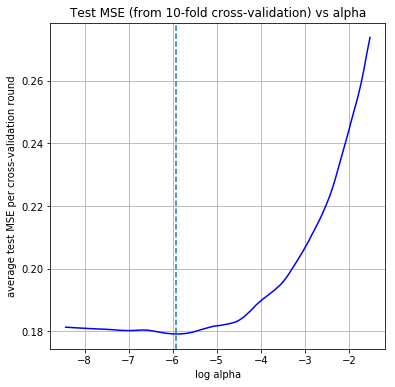

In [76]:
plt.figure(figsize=(6, 6))
plt.xlabel('log alpha')
plt.ylabel('average test MSE per cross-validation round')
plt.title('Test MSE (from 10-fold cross-validation) vs alpha')
plt.plot(np.log(lassocv.alphas_), test_MSE_per_alpha, color='blue')
plt.axvline(x=np.log(lassocv.alpha_), linestyle='--')
plt.grid()
plt.show()

In [77]:
features_lassocv_coefs = pd.DataFrame({'feature':X_tr_features2.columns, 'lassocv_coefficient':lassocv.coef_})

In [78]:
# LassoCV gets rid of 11 features.
print(features_lassocv_coefs[features_lassocv_coefs['lassocv_coefficient'] == 0].shape)
features_lassocv_coefs[features_lassocv_coefs['lassocv_coefficient'] == 0]

(11, 2)


,feature,lassocv_coefficient
3,median_hh_income,-0.0
11,median_age median_hh_income,-0.0
18,percent_white median_hh_income,-0.0
24,hs_percent median_hh_income,-0.0
28,hs_percent pmp_age_in_2016,0.0
35,percent_unemployed percent_poverty,0.0
36,percent_unemployed opioid_rx_rate_2014,-0.0
39,percent_poverty opioid_rx_rate_2014,-0.0
40,percent_poverty pmp_age_in_2016,-0.0
44,Division_East_North_Central,0.0


In [79]:
# LassoCV keeps in 41 features.
lassocv_features = features_lassocv_coefs[features_lassocv_coefs['lassocv_coefficient'] != 0]

In [80]:
lassocv_features

,feature,lassocv_coefficient
0,median_age,0.146428
1,percent_white,0.130639
2,hs_percent,-0.064556
4,percent_unemployed,0.059996
5,percent_poverty,0.041706
6,opioid_rx_rate_2014,0.114914
7,pmp_age_in_2016,0.076207
8,median_age^2,-0.029220
9,median_age percent_white,0.027048
10,median_age hs_percent,-0.052779


In [81]:
alphas = lassocv.alphas_[40:]
best_alpha = lassocv.alpha_
r2_lassocv = lassocv.score(X_tr_features2, y_tr)
print(best_alpha)
print(r2_lassocv)

# We can see that the R2 from the model that lasso gives us is slightly lower than the backwards elimination
# model, which gave R2 of 0.43

0.0026934802510844005
0.42767747752790247


In [82]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_tr_features2, y_tr)
    coefs.append(lasso.coef_)

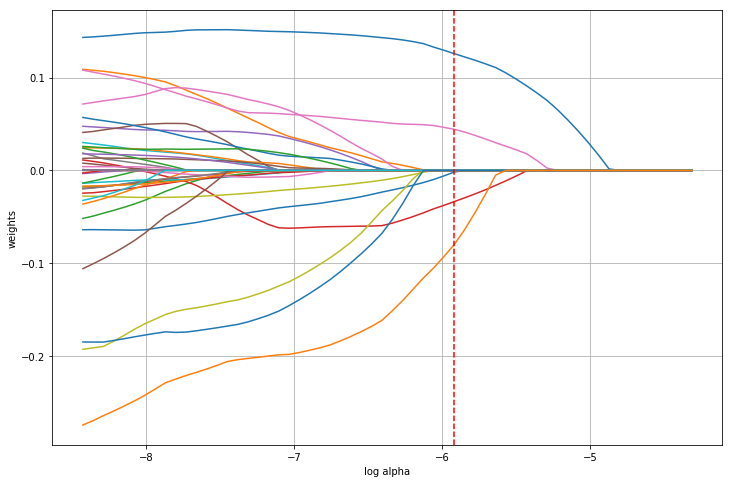

In [83]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(np.log(alphas), coefs)
ax.grid()
plt.axis('tight')
plt.xlabel('log alpha')
plt.ylabel('weights')
plt.axvline(x=np.log(best_alpha), color='red', linestyle='--')
plt.show()

In [61]:
%%capture
# Let's try using validation_curve to create a graph of test vs training error.

from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(Lasso(), X_tr_features2, y_tr, "alpha", np.logspace(-8, 5, 10), scoring='neg_mean_squared_error');

In [62]:
ave_test_scores = test_scores.mean(axis=1)
ave_train_scores = train_scores.mean(axis=1)
x_axis = range(0, 10)

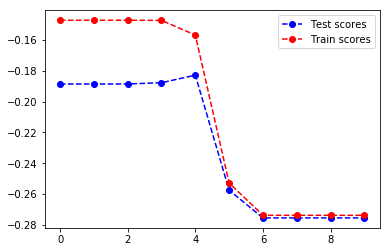

In [63]:
plt.plot(x_axis, ave_test_scores, 'bo--', label='Test scores')
plt.plot(x_axis, ave_train_scores, 'ro--', label='Train scores')
plt.legend()

### Learning Curve

Now, we can run a learning curve on both the backwards elimination model and the Lasso CV model.

In [69]:
# Learning Curve
from sklearn.model_selection import learning_curve

In [70]:
lr = LinearRegression()
lr.fit(X_tr_features2[backwards_elimination_features], y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
train_sizes, train_scores, test_scores = learning_curve(lr, X_tr_features2, y_tr, cv= 10)

In [72]:
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
learn_df

,train_size,train_score,test_score
0,72,0.876987,-4.359397
1,234,0.491127,0.162065
2,396,0.461537,0.265788
3,558,0.449360,0.299310
4,720,0.446370,0.320572


(-1, 1)

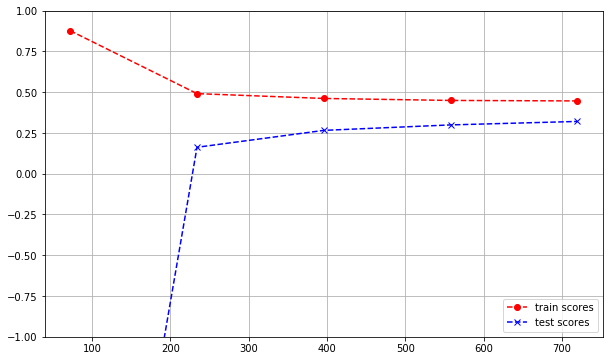

In [73]:
plt.figure(figsize=(10,6))
plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.grid()
plt.legend(loc='lower right')
plt.ylim(-1,1)

In [93]:
# We now use the alpha that LassoCV gave us to make a lasso model and set it to the best_alpha.
# We then fit this best_lasso to the full training set, and this is the model that we are going to run on the
# final test set.
best_lasso = Lasso()
best_lasso.set_params(alpha=best_alpha)
best_lasso.fit(X_tr_features2, y_tr)

Lasso(alpha=0.0026934802510844005, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
%%capture

train_sizes, train_scores, test_scores = learning_curve(lasso, X_tr_features2, y_tr, cv= 10);

ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})

(-1, 1)

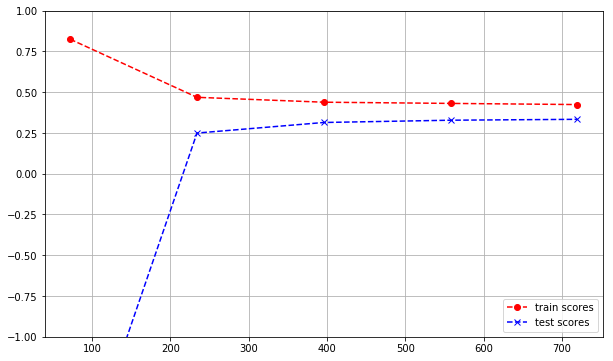

In [76]:
plt.figure(figsize=(10,6))
plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.grid()
plt.legend(loc='lower right')
plt.ylim(-1,1)

## Final test score

The steps here are to use the scaler that was used on X_tr_features2, and use it to scale the final X test set. After the final X test set is scaled, then you need to add the polynomial features to it as well, and then finally you can run your backwards elimination model and also your lasso_cv model on the final test set. Then report the r2 and the adjusted r2 for both.

In [84]:
# X_final_test and y_final_test are the final test set that will be used at the very end.
X_tr, X_final_test, y_tr, y_final_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
# Here, we use the scaler that we trained earlier and use it to transform the final test set.
X_ft_scaled = ssX.transform(X_final_test.iloc[:, :-8])

poly = PolynomialFeatures(2)
X_ft_quad = poly.fit_transform(X_ft_scaled)

X_ft_features = np.concatenate([X_ft_quad, X_final_test.iloc[:,-8:]], axis=1)

In [86]:
X_ft_features2 = pd.DataFrame(X_ft_features, columns=[list(poly.get_feature_names()) + list(X_final_test.columns[-8:])])
X_ft_features2.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x0^2,...,x6 x7,x7^2,Division_East_North_Central,Division_East_South_Central,Division_Middle_Atlantic,Division_Mountain,Division_Pacific,Division_South_Atlantic,Division_West_North_Central,Division_West_South_Central
0,1.0,0.092420,-1.584428,-0.686618,-1.383861,0.418201,1.216593,-0.039764,-0.427420,0.008541,...,0.016996,0.182688,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.969298,0.948734,-0.114477,-0.718744,-0.036860,-0.157118,-0.082414,1.338550,0.939538,...,-0.110315,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.691263,0.989924,0.122270,-0.557513,-0.491921,-0.179275,0.208137,1.338550,0.477845,...,0.278602,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,-0.313938,-0.589012,0.220915,-0.750197,1.419335,1.127966,0.450707,-0.482606,0.098557,...,-0.217514,0.232909,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,-0.100066,0.818301,1.345468,-0.473567,-0.400909,-0.467311,-0.055758,0.455565,0.010013,...,-0.025401,0.207539,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
temp = X_ft_features2.T.reset_index(drop=True).T
temp.columns = rename_features

In [88]:
X_ft_features2 = temp

In [89]:
# All of the other processing steps that happend before (scaling, adding quad features, etc.) got rid of INCITS
# as the index, need to get the index from X_tr and restore it.
orig_index = X_final_test.index
X_ft_features2.index = orig_index

In [90]:
X_ft_features2.head()

,const,median_age,percent_white,hs_percent,median_hh_income,percent_unemployed,percent_poverty,opioid_rx_rate_2014,pmp_age_in_2016,median_age^2,...,opioid_rx_rate_2014 pmp_age_in_2016,pmp_age_in_2016^2,Division_East_North_Central,Division_East_South_Central,Division_Middle_Atlantic,Division_Mountain,Division_Pacific,Division_South_Atlantic,Division_West_North_Central,Division_West_South_Central
INCITS,,,,,,,,,,,,,,,,,,,,,
35039,1.0,0.092420,-1.584428,-0.686618,-1.383861,0.418201,1.216593,-0.039764,-0.427420,0.008541,...,0.016996,0.182688,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
42033,1.0,0.969298,0.948734,-0.114477,-0.718744,-0.036860,-0.157118,-0.082414,1.338550,0.939538,...,-0.110315,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
42039,1.0,0.691263,0.989924,0.122270,-0.557513,-0.491921,-0.179275,0.208137,1.338550,0.477845,...,0.278602,1.791715,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
39095,1.0,-0.313938,-0.589012,0.220915,-0.750197,1.419335,1.127966,0.450707,-0.482606,0.098557,...,-0.217514,0.232909,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26103,1.0,-0.100066,0.818301,1.345468,-0.473567,-0.400909,-0.467311,-0.055758,0.455565,0.010013,...,-0.025401,0.207539,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
# For the backwards elimination lr model trained on the full training set, let's see how it does with predicting
# the y for the final test data set.
lr_backwards_elimination = LinearRegression()
lr_backwards_elimination.fit(X_tr_features2[backwards_elimination_features], y_tr)
y_final_test_predicted = lr_backwards_elimination.predict(X_ft_features2[backwards_elimination_features])
y_ft_resid = y_final_test - y_final_test_predicted
lr_be_final_test_MSE = sum(y_ft_resid**2)/len(y_ft_resid)
print(lr_be_final_test_MSE)

0.18079057323833528


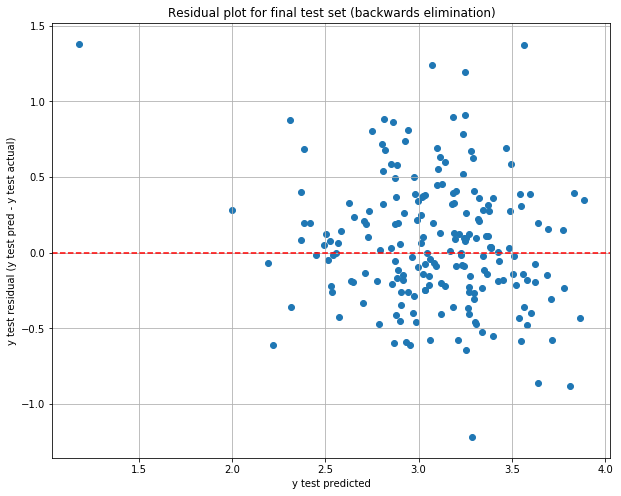

In [86]:
# Residual plot for backwards elimination linear model:
plt.figure(figsize=(10,8))
plt.scatter(y_final_test_predicted, y_ft_resid)
plt.grid()
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('y test predicted')
plt.ylabel('y test residual (y test pred - y test actual)')
plt.title('Residual plot for final test set (backwards elimination)')
plt.show()

In [87]:
# Now, we can join X_tr_features2 and X_ft_features2 (as well as y_tr and y_final_test) and train our model
# on the full data set, and look at the scores for it.

X_features2 = pd.concat([X_tr_features2, X_ft_features2], sort=True)
y = pd.concat([y_tr, y_final_test], sort=True)

#need to drop the 1s column, probably leftover from X_ft_features2
X_features2 = X_features2.drop('const', axis=1)

In [90]:
target = z['log_crude_rate']
predictors = z.iloc[:, 1:]

In [91]:
model = sm.OLS(target, sm.add_constant(predictors[backwards_elimination_features]))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_crude_rate   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     25.37
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           3.83e-96
Time:                        06:39:05   Log-Likelihood:                -495.14
No. Observations:                1000   AIC:                             1048.
Df Residuals:                     971   BIC:                             1191.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    3.4900      0.065     53.599      0.000       3.362       3.618
median_age percent_white                 0.0087      0.020      0.426      0.670      -0.031       0.049
pmp_age_in_2016                          0.0217      0.018      1.203      0.229      -0.014       0.057
opioid_rx_rate_2014^2                   -0.0156      0.010     -1.536      0.125      -0.036       0.004
percent_unemployed                       0.0236      0.019      1.243      0.214      -0.014       0.061
percent_unemployed pmp_age_in_2016      -0.0120      0.013     -0.920      0.358      -0.038       0.014
Division_Middle_Atlantic                -0.1416      0.073     -1.937      0.053      -0.285       0.002
median_hh_income pmp_age_in_2016        -0.0415      0.014     -2.963      0.003      -0.069      -0.014
median_age percent_unemployed           -0.0173      0.015     -1.115      0.265      -0.048       0.013
hs_percent                              -0.0444      0.025     -1.760      0.079      -0.094       0.005
percent_unemployed^2                     0.0232      0.010      2.249      0.025       0.003       0.043
median_hh_income percent_unemployed      0.0720      0.018      3.948      0.000       0.036       0.108
median_age^2                            -0.0329      0.008     -4.194      0.000      -0.048      -0.018
percent_white opioid_rx_rate_2014        0.0419      0.015      2.868      0.004       0.013       0.070
percent_white                            0.0899      0.021      4.307      0.000       0.049       0.131
hs_percent percent_poverty               0.0562      0.015      3.812      0.000       0.027       0.085
median_hh_income percent_poverty        -0.1038      0.023     -4.468      0.000      -0.149      -0.058
Division_East_North_Central             -0.2058      0.068     -3.009      0.003      -0.340      -0.072
Division_Mountain                       -0.2663      0.081     -3.274      0.001      -0.426      -0.107
Division_East_South_Central             -0.3009      0.079     -3.814      0.000      -0.456      -0.146
Division_South_Atlantic                 -0.2896      0.070     -4.110      0.000      -0.428      -0.151
percent_poverty                          0.0838      0.029      2.921      0.004       0.027       0.140
Division_Pacific                        -0.4672      0.081     -5.787      0.000      -0.626      -0.309
Division_West_North_Central             -0.4411      0.085     -5.164      0.000      -0.609      -0.274
median_age hs_percent                   -0.0648      0.016     -4.143      0.000      -0.096      -0.034
median_hh_income opioid_rx_rate_2014     0.0774      0.024      3.271      0.001       0.031       0.124
Division_West_South_Central           

In [92]:
backwards_elimination_predict_full_set = result.predict()
backwards_elimination_resid_full_set = result.resid

In [93]:
resid_df = pd.DataFrame({'y_predict': result.predict(), 'y_resid': result.resid})

In [94]:
y.head()
resid_df['y_true'] = y

In [109]:
resid_df.head()

,y_predict,y_resid,y_true
INCITS,,,
04015,3.658467,-0.234204,3.424263
36021,3.317054,-0.183520,3.133534
40051,2.798641,0.370438,3.169079
36081,2.974979,-0.457282,2.517696
47177,3.494105,-0.288046,3.206058


In [110]:
with open('be_full_set_true_pred_res.pkl', 'wb') as picklefile:
    pickle.dump(resid_df, picklefile)

In [97]:
resid_df.loc['24510']

y_predict    3.024550
y_resid      1.413384
y_true       4.437934
Name: 24510, dtype: float64

In [98]:
result.params.sort_values(ascending=False)

const                                   3.490030
median_age                              0.148329
opioid_rx_rate_2014                     0.128824
percent_white                           0.089898
percent_poverty                         0.083770
median_hh_income opioid_rx_rate_2014    0.077432
median_hh_income percent_unemployed     0.072034
hs_percent percent_poverty              0.056224
percent_white opioid_rx_rate_2014       0.041859
percent_unemployed                      0.023606
percent_unemployed^2                    0.023187
pmp_age_in_2016                         0.021705
median_age percent_white                0.008715
percent_unemployed pmp_age_in_2016     -0.012029
opioid_rx_rate_2014^2                  -0.015634
median_age percent_unemployed          -0.017263
median_age^2                           -0.032893
median_hh_income pmp_age_in_2016       -0.041456
hs_percent                             -0.044375
median_age hs_percent                  -0.064842
median_hh_income per

In [ ]:
# Now, let's use the best_lasso on the final test set. First we have to get rid of the first columns of 1s.
X_ft_features2 = X_ft_features2.drop('const', axis=1)
X_ft_features2.columns

In [96]:
# Fit the best_lasso to the whole training set. The best_lasso has the alpha that we got from LassoCV, where
# alpha is equal to roughly 10^-2.57
best_lasso.fit(X_tr_features2, y_tr);

In [97]:
y_ft_lasso_pred = best_lasso.predict(X_ft_features2)

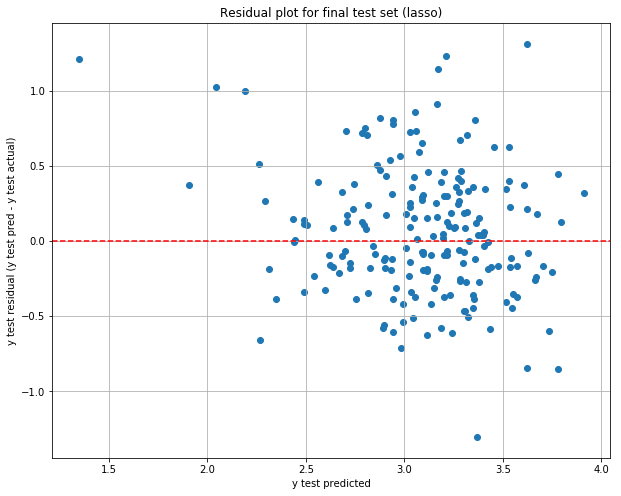

In [98]:
# Residual plot for the lasso linear model:
plt.figure(figsize=(10,8))
plt.scatter(y_ft_lasso_pred, y_final_test - y_ft_lasso_pred)
plt.grid()
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('y test predicted')
plt.ylabel('y test residual (y test pred - y test actual)')
plt.title('Residual plot for final test set (lasso)')

fig = plt.gcf()
fig.savefig('pics/lasso_residual_plot.png')

plt.show()

In [99]:
y_lasso_resid = y_final_test - y_ft_lasso_pred
lasso_test_MSE = sum(y_lasso_resid**2)/len(y_final_test)
print(lasso_test_MSE)

0.18499478961891086


In [ ]:
best_lasso.fit(X_features2, y);

# This is the R2 for the linear regression model that best lasso fits to the entire data set.
best_lasso.score(X_features2, y) 